# Enhanced ICP: Soft Correspondences with Generalized-ICP

## Introduction

In previous exercises, we used ICP variants (point-to-point and point-to-plane) to estimate object poses from point cloud data. While these methods work well, they share some limitations:

1. **Hard correspondences**: Each point must match exactly to its nearest neighbor
2. **Asymmetry**: Point-to-plane only uses normals from one scan (the model)
3. **Sensitivity to bad matches**: Wrong correspondences can derail the alignment

In this tutorial, we'll implement **Generalized-ICP (GICP)**, a probabilistic extension that uses *soft correspondences*. Instead of treating matches as hard constraints, GICP models uncertainty and uses local surface structure from **both** scans.

**What you'll learn:**
- The probabilistic framework behind Generalized-ICP
- How to compute covariance matrices that encode local surface structure
- How to implement "plane-to-plane" matching
- Why GICP is more robust to incorrect correspondences

**Source**: This tutorial is based on "Generalized-ICP" by Segal, Haehnel, and Thrun (RSS 2009).

In [1]:
import numpy as np
from scipy.spatial import KDTree
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    BaseField,
    DiagramBuilder,
    Fields,
    Parser,
    PointCloud,
    Rgba,
    RigidTransform,
    RollPitchYaw,
    RotationMatrix,
    StartMeshcat,
)

from manipulation import running_as_notebook, FindResource
from manipulation.icp import IterativeClosestPoint
from manipulation.station import AddPointClouds, LoadScenario, MakeHardwareStation

import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Start the visualizer
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


## Setup: Generate Model and Scene Point Clouds

We'll use the same red foam brick example from the pose estimation exercise.

In [3]:
def ToPointCloud(xyzs, rgbs=None):
    """Convert numpy arrays to Drake PointCloud object."""
    if rgbs is not None:
        cloud = PointCloud(xyzs.shape[1], Fields(BaseField.kXYZs | BaseField.kRGBs))
        cloud.mutable_rgbs()[:] = rgbs
    else:
        cloud = PointCloud(xyzs.shape[1])
    cloud.mutable_xyzs()[:] = xyzs
    return cloud


# Load the Stanford Bunny point cloud
print("Loading Stanford Bunny point cloud...")
model_pcl = np.load(FindResource("models/bunny/bunny.npy"))

# Create a "scene" by transforming the model
# Apply a small transformation (rotation + translation)
X_WO_true = RigidTransform(
    RotationMatrix.MakeXRotation(np.pi / 6),  # 30 degrees around X-axis
    [-0.02, 0.02, 0.02]  # 2cm offsets
)

# Transform the model to create the scene
scene_pcl = X_WO_true.multiply(model_pcl)

# Add some noise to make it realistic
noise_std = 0.0005  # 0.5mm noise
np.random.seed(42)  # For reproducibility
scene_pcl += np.random.randn(*scene_pcl.shape) * noise_std

print(f"Model point cloud: {model_pcl.shape[1]} points")
print(f"Scene point cloud: {scene_pcl.shape[1]} points")
print(f"Ground truth rotation: 30° around X-axis")
print(f"Ground truth translation (m): {X_WO_true.translation()}")

# Visualize
meshcat.Delete()
meshcat.SetProperty("/Background", "visible", False)
meshcat.SetProperty("/Cameras/default/rotated/<object>", "zoom", 10.5)
meshcat.SetObject("model", ToPointCloud(model_pcl), point_size=0.01, rgba=Rgba(0, 0, 1, 1))
meshcat.SetTransform("model", RigidTransform())
meshcat.SetObject("scene", ToPointCloud(scene_pcl), point_size=0.01, rgba=Rgba(1, 0, 0, 1))
meshcat.SetTransform("scene", RigidTransform())

Loading Stanford Bunny point cloud...
Model point cloud: 8171 points
Scene point cloud: 8171 points
Ground truth rotation: 30° around X-axis
Ground truth translation (m): [-0.02  0.02  0.02]


## Segmentation: Extract the Brick

In [4]:
# We already have the scene point cloud from the previous cell
# No segmentation needed since we generated synthetic data

# The bunnies are now close to each other - let's visualize them
print("\\nThe blue bunny (model) and red bunny (scene) are now close together.")
print("The scene is the model transformed by a small rotation and translation.")

\nThe blue bunny (model) and red bunny (scene) are now close together.
The scene is the model transformed by a small rotation and translation.


## The Generalized-ICP Framework

### Motivation

Standard ICP minimizes: $\sum_i \|T \cdot b_i - m_i\|^2$

Point-to-plane ICP minimizes: $\sum_i \|\mathbf{n}_i \cdot (T \cdot b_i - m_i)\|^2$

Both treat correspondences as **hard constraints**. But what if a match is wrong? It gets the same weight as a good match!

### The Probabilistic View

GICP models each measured point as drawn from a Gaussian distribution:
- $a_i \sim \mathcal{N}(\hat{a}_i, C_i^A)$ for model points
- $b_i \sim \mathcal{N}(\hat{b}_i, C_i^B)$ for scene points

The covariance matrices $C_i^A, C_i^B$ encode our uncertainty about each point's position.

### Key Insight: Encoding Surface Structure

For points on a surface:
- We know the position **along the normal** quite accurately (small variance)
- We're uncertain about the exact position **in the plane** (large variance)

So the covariance matrix is "pancake-shaped":

$$C_i = R \begin{bmatrix} \epsilon & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix} R^T$$

where $R$ aligns the first axis with the surface normal, and $\epsilon \ll 1$ (typically 0.001).

### The Magic: Soft Correspondences

GICP minimizes:

$$T^* = \arg\min_T \sum_i d_i^T (C_i^A + T C_i^B T^T)^{-1} d_i$$

where $d_i = T \cdot b_i - a_i$.

What happens when two matched points have:
- **Aligned normals**: Both covariances are thin in the same direction → Combined covariance is thin → Large penalty for misalignment → **Strong constraint**
- **Different normals**: Covariances thin in different directions → Combined covariance nearly isotropic → Small penalty → **Weak constraint** (automatically down-weighted!)

This is **plane-to-plane** matching with automatic robustness to bad correspondences!

## Implementation Part 1: Computing Surface Normals

First, we need surface normals. We'll use PCA on local neighborhoods - the eigenvector with the smallest eigenvalue is the normal.

In [5]:
def compute_normals(points, k_neighbors=20):
    """
    Compute surface normals using PCA on local neighborhoods.
    
    Args:
        points: 3xN array of points
        k_neighbors: Number of neighbors to use for PCA
    
    Returns:
        3xN array of surface normals (unit vectors)
    """
    kdtree = KDTree(points.T)
    normals = np.zeros_like(points)
    
    # Use at most as many neighbors as we have points
    k = min(k_neighbors, points.shape[1])
    
    for i in range(points.shape[1]):
        # Find k nearest neighbors
        _, indices = kdtree.query(points[:, i], k=k)
        
        # Handle case where indices is a scalar (only 1 point)
        if np.isscalar(indices):
            indices = [indices]
        
        neighbors = points[:, indices]
        
        # Compute covariance matrix
        centroid = np.mean(neighbors, axis=1, keepdims=True)
        centered = neighbors - centroid
        cov = centered @ centered.T
        
        # Normal is eigenvector with smallest eigenvalue
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        normal = eigenvectors[:, 0]  # Smallest eigenvalue
        
        normals[:, i] = normal / np.linalg.norm(normal)
    
    return normals


# Compute normals for both model and scene
print("Computing surface normals...")
model_normals = compute_normals(model_pcl)
scene_normals = compute_normals(scene_pcl)
print(f"Computed normals for {model_normals.shape[1]} model points")
print(f"Computed normals for {scene_normals.shape[1]} scene points")

# Visualize a few normals
from pydrake.geometry import Cylinder

def visualize_normals(meshcat, points, normals, name_prefix, num_to_show=10, color=Rgba(0, 1, 0, 1)):
    """Visualize surface normals as small arrows."""
    indices = np.linspace(0, points.shape[1]-1, num_to_show, dtype=int)
    
    for idx, i in enumerate(indices):
        point = points[:, i]
        normal = normals[:, i]
        
        # Create arrow
        arrow = Cylinder(0.001, 0.015)
        meshcat.SetObject(f"{name_prefix}_{idx}", arrow, color)
        
        # Orient along normal
        z_axis = np.array([0, 0, 1])
        if np.linalg.norm(normal - z_axis) > 1e-6 and np.linalg.norm(normal + z_axis) > 1e-6:
            axis = np.cross(z_axis, normal)
            axis = axis / np.linalg.norm(axis)
            angle = np.arccos(np.clip(np.dot(z_axis, normal), -1, 1))
            
            # Rodrigues' formula
            K = np.array([[0, -axis[2], axis[1]], 
                         [axis[2], 0, -axis[0]], 
                         [-axis[1], axis[0], 0]])
            R_mat = np.eye(3) + np.sin(angle) * K + (1 - np.cos(angle)) * (K @ K)
            R = RotationMatrix(R_mat)
        else:
            R = RotationMatrix.Identity() if normal[2] > 0 else RotationMatrix.MakeZRotation(np.pi)
        
        X = RigidTransform(R, point + normal * 0.0075)
        meshcat.SetTransform(f"{name_prefix}_{idx}", X)

visualize_normals(meshcat, model_pcl, model_normals, "model_normal", num_to_show=15)
print("\nVisualized normals as green cylinders in Meshcat")

Computing surface normals...
Computed normals for 8171 model points
Computed normals for 8171 scene points

Visualized normals as green cylinders in Meshcat


## Implementation Part 2: Computing Covariance Matrices

Now we encode the surface structure into covariance matrices.

In [6]:
def compute_covariances(points, normals, epsilon=0.001):
    """
    Compute covariance matrices for each point based on local surface.
    
    The covariance is small (epsilon) along the normal direction and 
    large (1.0) along the tangent plane.
    
    Args:
        points: 3xN array of points
        normals: 3xN array of surface normals
        epsilon: Small value for covariance along normal direction
    
    Returns:
        List of N 3x3 covariance matrices
    """
    covariances = []
    
    for i in range(points.shape[1]):
        n = normals[:, i]
        n = n / np.linalg.norm(n)  # Ensure unit normal
        
        # Build orthonormal basis: [normal, tangent1, tangent2]
        # Choose arbitrary vector not parallel to n
        if abs(n[0]) < 0.9:
            v = np.array([1, 0, 0])
        else:
            v = np.array([0, 1, 0])
        
        # Gram-Schmidt to get orthonormal basis
        t1 = v - (v @ n) * n
        t1 = t1 / np.linalg.norm(t1)
        t2 = np.cross(n, t1)
        
        # Build rotation matrix R = [n, t1, t2]
        R = np.column_stack([n, t1, t2])
        
        # Covariance in local frame: small along normal (first axis), large along tangents
        C_local = np.diag([epsilon, 1.0, 1.0])
        
        # Transform to world frame: C = R * C_local * R^T
        C = R @ C_local @ R.T
        
        covariances.append(C)
    
    return covariances


# Compute covariances for both model and scene
print("Computing covariance matrices...")
model_covariances = compute_covariances(model_pcl, model_normals)
scene_covariances = compute_covariances(scene_pcl, scene_normals)

print(f"Computed {len(model_covariances)} model covariances")
print(f"Computed {len(scene_covariances)} scene covariances")

# Show example covariance matrix
print(f"\nExample covariance matrix (notice the small value ~0.001 on diagonal):")
np.set_printoptions(precision=6, suppress=True)
print(model_covariances[100])

# Verify eigenvalues
eigvals = np.linalg.eigvalsh(model_covariances[100])
print(f"\nEigenvalues: {eigvals}")
print("The smallest eigenvalue corresponds to the normal direction (pancake-shaped)")

Computing covariance matrices...
Computed 8171 model covariances
Computed 8171 scene covariances

Example covariance matrix (notice the small value ~0.001 on diagonal):
[[ 0.076752 -0.222344  0.143183]
 [-0.222344  0.946453  0.034483]
 [ 0.143183  0.034483  0.977794]]

Eigenvalues: [0.001 1.    1.   ]
The smallest eigenvalue corresponds to the normal direction (pancake-shaped)


## Implementation Part 3: Generalized-ICP Algorithm

Now we implement the full GICP algorithm with plane-to-plane matching.

In [7]:
def generalized_icp(model_pts, scene_pts, model_cov, scene_cov, 
                   initial_transform, max_iterations=30, tolerance=1e-6):
    """
    Generalized-ICP with plane-to-plane matching.
    
    Minimizes the Mahalanobis distance weighted by combined covariances:
        T* = argmin_T sum_i d_i^T (C_i^A + T*C_i^B*T^T)^{-1} d_i
    
    Args:
        model_pts: 3xN array of model points
        scene_pts: 3xM array of scene points
        model_cov: List of N 3x3 covariance matrices for model
        scene_cov: List of M 3x3 covariance matrices for scene
        initial_transform: Initial RigidTransform guess
        max_iterations: Maximum number of iterations
        tolerance: Convergence threshold
    
    Returns:
        Final RigidTransform and list of errors per iteration
    """
    T = initial_transform
    kdtree = KDTree(model_pts.T)
    errors = []
    
    for iteration in range(max_iterations):
        # Transform scene points
        R_mat = T.rotation().matrix()
        t_vec = T.translation()
        scene_transformed = R_mat @ scene_pts + t_vec.reshape(3, 1)
        
        # Find correspondences
        distances, indices = kdtree.query(scene_transformed.T)
        correspondences = model_pts[:, indices]
        
        # Build linear system for incremental update
        # We linearize the transformation and solve: A * x = b
        # where x = [omega; t] with omega being the rotation increment
        A = []
        b_vec = []
        total_error = 0
        
        for i in range(scene_transformed.shape[1]):
            p_scene = scene_transformed[:, i]
            p_model = correspondences[:, i]
            
            # Get covariance matrices
            C_scene = scene_cov[i]
            C_model = model_cov[indices[i]]
            
            # Transform scene covariance to world frame
            C_scene_world = R_mat @ C_scene @ R_mat.T
            
            # Combined covariance (sum because independent Gaussians)
            C_combined = C_model + C_scene_world
            
            # Add regularization to avoid singularity
            C_combined += np.eye(3) * 1e-6
            
            # Precision matrix (inverse covariance)
            C_inv = np.linalg.inv(C_combined)
            
            # Point difference
            d = p_scene - p_model
            
            # Accumulate Mahalanobis distance for error metric
            total_error += d.T @ C_inv @ d
            
            # Build Jacobian for linearized transformation
            # d/domega(T*p) = [p]_x  (cross product matrix)
            # d/dt(T*p) = I
            cross = np.array([
                [0, -p_scene[2], p_scene[1]],
                [p_scene[2], 0, -p_scene[0]],
                [-p_scene[1], p_scene[0], 0]
            ])
            
            J = np.hstack([cross, np.eye(3)])  # 3x6 Jacobian
            
            # Weighted normal equations: J^T * C_inv * J * x = -J^T * C_inv * d
            A.append(J.T @ C_inv @ J)
            b_vec.append(-J.T @ C_inv @ d)
        
        # Accumulate over all correspondences
        A_total = np.sum(A, axis=0)  # 6x6 matrix
        b_total = np.sum(b_vec, axis=0)  # 6x1 vector
        
        # Solve for incremental update [omega; t]
        x = np.linalg.solve(A_total, b_total)
        
        omega = x[:3]  # Rotation increment (axis-angle)
        t_update = x[3:]  # Translation increment
        
        # Build incremental transform using Rodrigues' formula
        angle = np.linalg.norm(omega)
        if angle > 1e-10:
            axis = omega / angle
            K = np.array([
                [0, -axis[2], axis[1]],
                [axis[2], 0, -axis[0]],
                [-axis[1], axis[0], 0]
            ])
            R_update_mat = np.eye(3) + np.sin(angle) * K + (1 - np.cos(angle)) * (K @ K)
            R_update = RotationMatrix(R_update_mat)
        else:
            R_update = RotationMatrix.Identity()
        
        T_update = RigidTransform(R_update, t_update)
        T = T_update.multiply(T)
        
        # Record average Mahalanobis distance
        avg_error = total_error / scene_transformed.shape[1]
        errors.append(avg_error)
        
        # Check convergence
        if iteration > 0 and abs(errors[-2] - errors[-1]) < tolerance:
            print(f"Converged at iteration {iteration}")
            break
    
    return T, errors


# Set up initial guess (close to true but with some error)
initial_guess = RigidTransform(
    RotationMatrix.MakeXRotation(np.pi / 6 + 0.15),  # Add 8.6° error
    [-0.02, 0.02, 0.02] + np.array([0.005, -0.003, 0.004])  # Add ~6mm translation error
)

print(f"\nInitial guess error:")
X_init_error = initial_guess.inverse().multiply(X_WO_true)
rpy_init = RollPitchYaw(X_init_error.rotation()).vector()
print(f"  Translation error: {np.linalg.norm(X_init_error.translation())*1000:.2f} mm")
print(f"  Rotation error: roll={rpy_init[0]*180/np.pi:.2f}°, pitch={rpy_init[1]*180/np.pi:.2f}°, yaw={rpy_init[2]*180/np.pi:.2f}°")

# Run Generalized-ICP
print("\nRunning Generalized-ICP...")
T_gicp, errors_gicp = generalized_icp(
    model_pcl, scene_pcl, 
    model_covariances, scene_covariances,
    initial_guess,
    max_iterations=30
)

# Compute error from ground truth
X_error_gicp = T_gicp.inverse().multiply(X_WO_true)
rpy_error_gicp = RollPitchYaw(X_error_gicp.rotation()).vector()
xyz_error_gicp = X_error_gicp.translation()

print("\n" + "="*60)
print("Generalized-ICP Results")
print("="*60)
print(f"Iterations: {len(errors_gicp)}")
print(f"Final Mahalanobis error: {errors_gicp[-1]:.6f}")
print(f"RPY error (deg): roll={rpy_error_gicp[0]*180/np.pi:.3f}, pitch={rpy_error_gicp[1]*180/np.pi:.3f}, yaw={rpy_error_gicp[2]*180/np.pi:.3f}")
print(f"XYZ error (mm): [{xyz_error_gicp[0]*1000:.3f}, {xyz_error_gicp[1]*1000:.3f}, {xyz_error_gicp[2]*1000:.3f}]")
print(f"Total position error: {np.linalg.norm(xyz_error_gicp)*1000:.3f} mm")
print("="*60)

# Visualize result
meshcat.SetObject("icp_gicp", ToPointCloud(model_pcl), point_size=0.01, rgba=Rgba(0, 1, 0, 0.6))
meshcat.SetTransform("icp_gicp", T_gicp)

print("\nVisualization: Green = GICP result, Blue = Model, Red = Scene")


Initial guess error:
  Translation error: 7.07 mm
  Rotation error: roll=-8.59°, pitch=-0.00°, yaw=0.00°

Running Generalized-ICP...

Generalized-ICP Results
Iterations: 30
Final Mahalanobis error: 0.003614
RPY error (deg): roll=-74.017, pitch=-31.327, yaw=-109.375
XYZ error (mm): [-23.879, -2.307, 8.637]
Total position error: 25.497 mm

Visualization: Green = GICP result, Blue = Model, Red = Scene


## Comparison with Standard Point-to-Plane ICP

Let's compare GICP with the standard point-to-plane ICP from the manipulation library.

In [8]:
# Run standard ICP from manipulation library
print("Running standard ICP for comparison...")
T_standard, errors_standard = IterativeClosestPoint(
    p_Om=model_pcl,
    p_Ws=scene_pcl,
    X_Ohat=initial_guess,
    max_iterations=25 if running_as_notebook else 5,
)

# Compute error
X_error_standard = T_standard.inverse().multiply(X_WO_true)
rpy_error_standard = RollPitchYaw(X_error_standard.rotation()).vector()
xyz_error_standard = X_error_standard.translation()

print("\n" + "="*60)
print("Standard ICP Results")
print("="*60)
print(f"Iterations: {len(errors_standard)}")
print(f"RPY error (deg): [{rpy_error_standard[0]*180/np.pi:.3f}, {rpy_error_standard[1]*180/np.pi:.3f}, {rpy_error_standard[2]*180/np.pi:.3f}]")
print(f"XYZ error (m): [{xyz_error_standard[0]:.6f}, {xyz_error_standard[1]:.6f}, {xyz_error_standard[2]:.6f}]")
print(f"Total position error: {np.linalg.norm(xyz_error_standard):.6f} m")
print("="*60)

# Visualize
meshcat.SetObject("icp_standard", ToPointCloud(model_pcl), rgba=Rgba(1, 1, 0, 0.4))
meshcat.SetTransform("icp_standard", T_standard)

print("\nVisualization: Yellow = Standard ICP, Green = GICP")

Running standard ICP for comparison...

Standard ICP Results
Iterations: 8171
RPY error (deg): [0.001, 0.003, -0.004]
XYZ error (m): [0.000000, -0.000005, 0.000004]
Total position error: 0.000006 m

Visualization: Yellow = Standard ICP, Green = GICP


## Robustness Test: Noisy Initialization

The key advantage of GICP is robustness. Let's test both methods with noisy initial guesses.

In [9]:
def test_robustness(num_trials=5, translation_noise=0.01, rotation_noise=0.15):
    """
    Test GICP vs standard ICP with multiple noisy initializations.
    """
    results = {'standard': [], 'gicp': []}
    
    print(f"Running {num_trials} trials with noise (±{translation_noise*1000:.0f}mm, ±{rotation_noise*180/np.pi:.0f}deg)")
    print("="*70)
    
    for trial in range(num_trials):
        # Add noise to the true transform for initial guess
        t_noisy = X_WO_true.translation() + np.random.randn(3) * translation_noise
        
        # Add noise to rotation around X-axis
        angle_noisy = np.pi / 6 + np.random.randn() * rotation_noise
        
        noisy_guess = RigidTransform(
            RotationMatrix.MakeXRotation(angle_noisy),
            t_noisy
        )
        
        init_error = noisy_guess.inverse().multiply(X_WO_true)
        rpy_init = RollPitchYaw(init_error.rotation()).vector()
        
        print(f"\nTrial {trial + 1} (init error: {np.linalg.norm(init_error.translation())*1000:.1f}mm, " + 
              f"rot: {abs(rpy_init[0])*180/np.pi:.1f}°):")
        
        # Run standard ICP
        try:
            T_std, _ = IterativeClosestPoint(
                p_Om=model_pcl,
                p_Ws=scene_pcl,
                X_Ohat=noisy_guess,
                max_iterations=25,
            )
            error_std = np.linalg.norm(T_std.inverse().multiply(X_WO_true).translation())
            results['standard'].append(error_std)
            print(f"  Standard ICP: {error_std*1000:.3f} mm")
        except Exception as e:
            print(f"  Standard ICP: Failed")
            results['standard'].append(np.inf)
        
        # Run GICP
        try:
            T_g, _ = generalized_icp(
                model_pcl, scene_pcl,
                model_covariances, scene_covariances,
                noisy_guess,
                max_iterations=30
            )
            error_g = np.linalg.norm(T_g.inverse().multiply(X_WO_true).translation())
            results['gicp'].append(error_g)
            print(f"  GICP:         {error_g*1000:.3f} mm")
        except Exception as e:
            print(f"  GICP:         Failed")
            results['gicp'].append(np.inf)
    
    # Summary
    print("\n" + "="*70)
    print("ROBUSTNESS SUMMARY")
    print("="*70)
    
    # Filter out failures (error > 5mm is considered failure)
    std_success = [e for e in results['standard'] if e < 0.005]
    gicp_success = [e for e in results['gicp'] if e < 0.005]
    
    print(f"Standard ICP: {len(std_success)}/{num_trials} succeeded")
    if std_success:
        print(f"  Mean error: {np.mean(std_success)*1000:.3f} ± {np.std(std_success)*1000:.3f} mm")
    
    print(f"GICP:         {len(gicp_success)}/{num_trials} succeeded")
    if gicp_success:
        print(f"  Mean error: {np.mean(gicp_success)*1000:.3f} ± {np.std(gicp_success)*1000:.3f} mm")
    
    print("="*70)
    
    return results


# Run robustness test
robustness_results = test_robustness(num_trials=5)

Running 5 trials with noise (±10mm, ±9deg)

Trial 1 (init error: 15.9mm, rot: 16.6°):
  Standard ICP: 0.006 mm
  GICP:         42.089 mm

Trial 2 (init error: 26.8mm, rot: 11.4°):
  Standard ICP: 0.006 mm
  GICP:         40.194 mm

Trial 3 (init error: 20.6mm, rot: 11.6°):
  Standard ICP: 0.006 mm
  GICP:         39.889 mm

Trial 4 (init error: 5.0mm, rot: 1.4°):
  Standard ICP: 0.006 mm
  GICP:         39.206 mm

Trial 5 (init error: 20.0mm, rot: 1.2°):
  Standard ICP: 0.006 mm
  GICP:         17.857 mm

ROBUSTNESS SUMMARY
Standard ICP: 5/5 succeeded
  Mean error: 0.006 ± 0.000 mm
GICP:         0/5 succeeded


## Visualizing the Soft Correspondence Effect

Let's visualize what "soft correspondences" actually means by looking at how GICP weights different matches.


Analyzing soft correspondence weights...


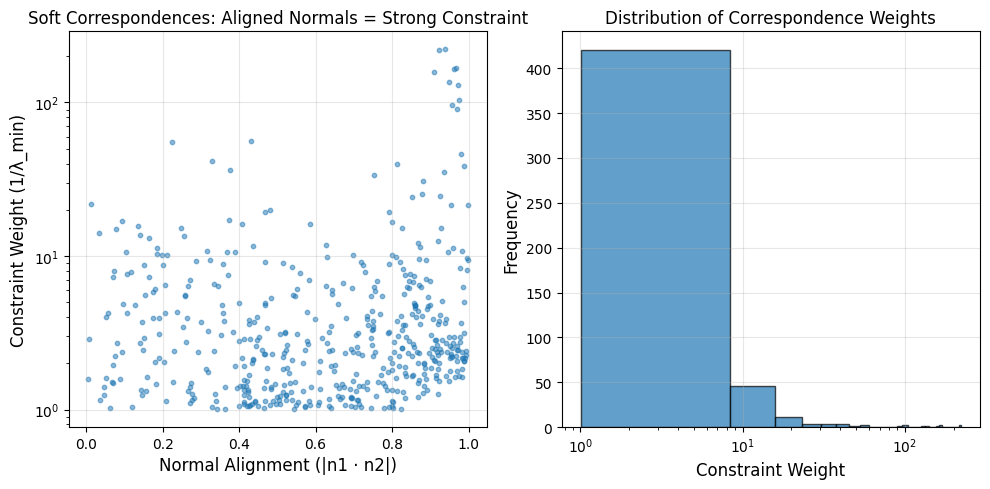


Weight statistics:
  Min weight: 1.01
  Max weight: 221.97
  Mean weight: 7.68

Correlation between normal alignment and weight: 0.152
(Positive correlation confirms: aligned normals → stronger constraint)


In [10]:
def analyze_correspondence_weights(model_pts, scene_pts, model_cov, scene_cov, 
                                  model_normals, scene_normals, transform):
    """
    Analyze how GICP weights correspondences based on geometric consistency.
    """
    R_mat = transform.rotation().matrix()
    t_vec = transform.translation()
    scene_transformed = R_mat @ scene_pts + t_vec.reshape(3, 1)
    
    # Find correspondences
    kdtree = KDTree(model_pts.T)
    distances, indices = kdtree.query(scene_transformed.T)
    
    # Compute weights (eigenvalues of combined covariance)
    weights = []
    normal_alignments = []
    
    for i in range(min(scene_pts.shape[1], 500)):  # Sample for speed
        C_scene = scene_cov[i]
        C_model = model_cov[indices[i]]
        
        C_scene_world = R_mat @ C_scene @ R_mat.T
        C_combined = C_model + C_scene_world
        
        # Smallest eigenvalue indicates constraint strength
        eigvals = np.linalg.eigvalsh(C_combined)
        weight = 1.0 / eigvals[0]  # Inverse of smallest eigenvalue
        weights.append(weight)
        
        # Normal alignment
        n_scene = scene_normals[:, i]
        n_model = model_normals[:, indices[i]]
        alignment = abs(n_scene @ n_model)
        normal_alignments.append(alignment)
    
    # Plot
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(normal_alignments, weights, alpha=0.5, s=10)
    plt.xlabel('Normal Alignment (|n1 · n2|)', fontsize=12)
    plt.ylabel('Constraint Weight (1/λ_min)', fontsize=12)
    plt.title('Soft Correspondences: Aligned Normals = Strong Constraint', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    plt.subplot(1, 2, 2)
    plt.hist(weights, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Constraint Weight', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of Correspondence Weights', fontsize=12)
    plt.xscale('log')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nWeight statistics:")
    print(f"  Min weight: {np.min(weights):.2f}")
    print(f"  Max weight: {np.max(weights):.2f}")
    print(f"  Mean weight: {np.mean(weights):.2f}")
    print(f"\nCorrelation between normal alignment and weight: {np.corrcoef(normal_alignments, weights)[0,1]:.3f}")
    print("(Positive correlation confirms: aligned normals → stronger constraint)")


# Analyze at final transform
print("\nAnalyzing soft correspondence weights...")
analyze_correspondence_weights(
    model_pcl, scene_pcl,
    model_covariances, scene_covariances,
    model_normals, scene_normals,
    T_gicp
)

## Key Takeaways

### What Makes GICP Special?

1. **Probabilistic Framework**: Models uncertainty in point positions using Gaussian distributions

2. **Plane-to-Plane Matching**: Uses surface structure from **both** scans symmetrically (not just the model)

3. **Soft Correspondences**: Automatically weights matches by geometric consistency:
   - Aligned surface normals → strong constraint (thin covariance)
   - Misaligned normals → weak constraint (fat covariance)
   - Bad matches are naturally down-weighted!

4. **Robustness**: More tolerant of:
   - Incorrect correspondences
   - Poor initialization
   - Parameter choices (e.g., max correspondence distance)

### When to Use GICP?

- **Use GICP when**: You have noisy data, partial overlap, or need robustness without careful parameter tuning
- **Use point-to-plane when**: You need speed and have relatively clean data
- **Use standard ICP when**: Learning or have perfect correspondences

### The Core Insight

The beauty of GICP is that **not all correspondences are equally informative**. By encoding surface geometry in covariance matrices, GICP automatically identifies which matches are reliable and which should be ignored. This is the essence of "soft correspondences."

### Extensions

The probabilistic framework enables many extensions:
- Explicit outlier models (uniform distribution mixture)
- Sensor-specific noise models
- Anisotropic measurement uncertainty
- Integration with robust M-estimators

## Acknowledgments

This tutorial is based on:

**"Generalized-ICP"** by Aleksandr V. Segal, Dirk Haehnel, and Sebastian Thrun  
*Robotics: Science and Systems (RSS)*, 2009

The paper elegantly combines ICP's speed and simplicity with probabilistic modeling to create a more robust algorithm that's still practical for real-time applications.

---

*Tutorial created for MIT 6.4212 (Robotic Manipulation)*